# User Experience Analytics
## Objective:
The goal of User Experience Analytics is to evaluate the network performance that affects the overall user experience. By analyzing network-related metrics such as TCP retransmissions, Round Trip Time (RTT), and throughput, you can determine how these metrics influence user experience. Ultimately, you'll be clustering users based on their experience and analyzing the patterns to understand which network parameters have the most impact.

### Metrics to Focus On:
* **TCP Retransmission**: Measures how often packets need to be resent, indicating potential network issues.
* **RTT (Round Trip Time)**: The time taken for a packet to travel to the destination and back. Lower RTT indicates a better experience.
* **Throughput**: Measures how much data can be sent through the network in a given time. Higher throughput generally means a better user experience.

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append(os.path.abspath('../scripts'))
from db_connection import load_data_from_postgres
sys.path.append(os.path.abspath('../src'))

from utils import visualize_missing_values, replace_missing_values, detect_outliers_zscore,\
    remove_outliers     

from experience_utils import aggregate_experience_metrics, normalize_experience_data, plot_elbow_method,\
    apply_kmeans, visualize_clusters_with_centroids

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# Define your SQL query
query = """
SELECT 
    "Bearer Id",
    "MSISDN/Number",
    "Avg RTT DL (ms)",
    "Avg RTT UL (ms)",
    "Avg Bearer TP DL (kbps)",
    "Avg Bearer TP UL (kbps)",
    "TCP DL Retrans. Vol (Bytes)",
    "TCP UL Retrans. Vol (Bytes)"
FROM xdr_data;
"""

# Load data from PostgreSQL
df = load_data_from_postgres(query)

if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")

/home/seife/Desktop/Kifiya_AIM/Tutor/Telecom-User-Analytics/scripts/db_connection.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Successfully loaded the data


In [3]:
df.head()

,Bearer Id,MSISDN/Number,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes)
0,1.311448e+19,3.366496e+10,42.0,5.0,23.0,44.0,NaN,NaN
1,1.311448e+19,3.368185e+10,65.0,5.0,16.0,26.0,NaN,NaN
2,1.311448e+19,3.376063e+10,NaN,NaN,6.0,9.0,NaN,NaN
3,1.311448e+19,3.375034e+10,NaN,NaN,44.0,44.0,NaN,NaN
4,1.311448e+19,3.369980e+10,NaN,NaN,6.0,9.0,NaN,NaN


In [4]:
df.tail()

,Bearer Id,MSISDN/Number,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes)
149996,7.277826e+18,3.365069e+10,32.0,0.0,52.0,65.0,NaN,NaN
149997,7.349883e+18,3.366345e+10,27.0,2.0,23.0,54.0,NaN,NaN
149998,1.311448e+19,3.362189e+10,43.0,6.0,43.0,47.0,NaN,NaN
149999,1.311448e+19,3.361962e+10,37.0,5.0,34.0,37.0,NaN,NaN
150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Preparation

### Visualize the missing values

<Axes: >

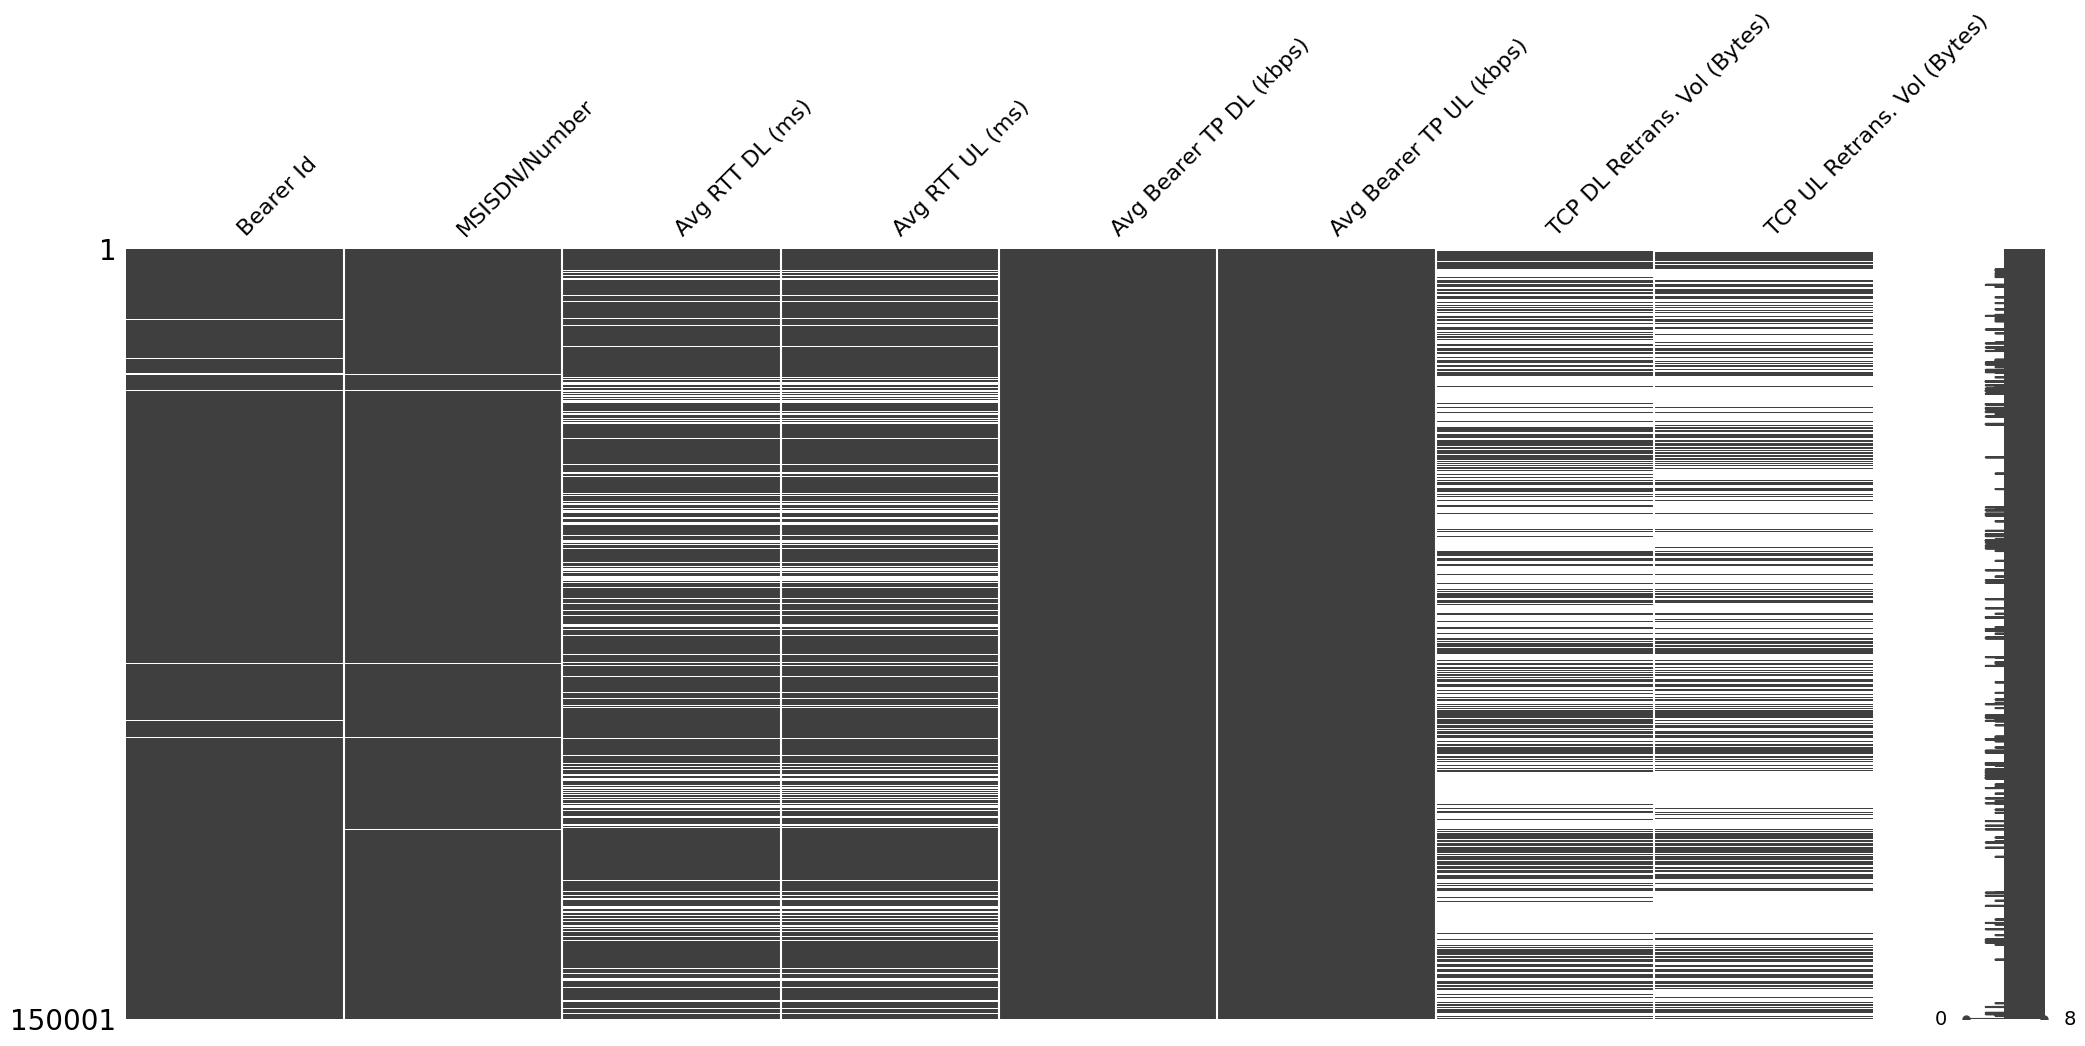

In [5]:
# Visualize missing values
visualize_missing_values(df)

### Replace missing values by median

Replacing 8 Numeric columns by mean value ...
Replacing Completed!!



<Axes: >

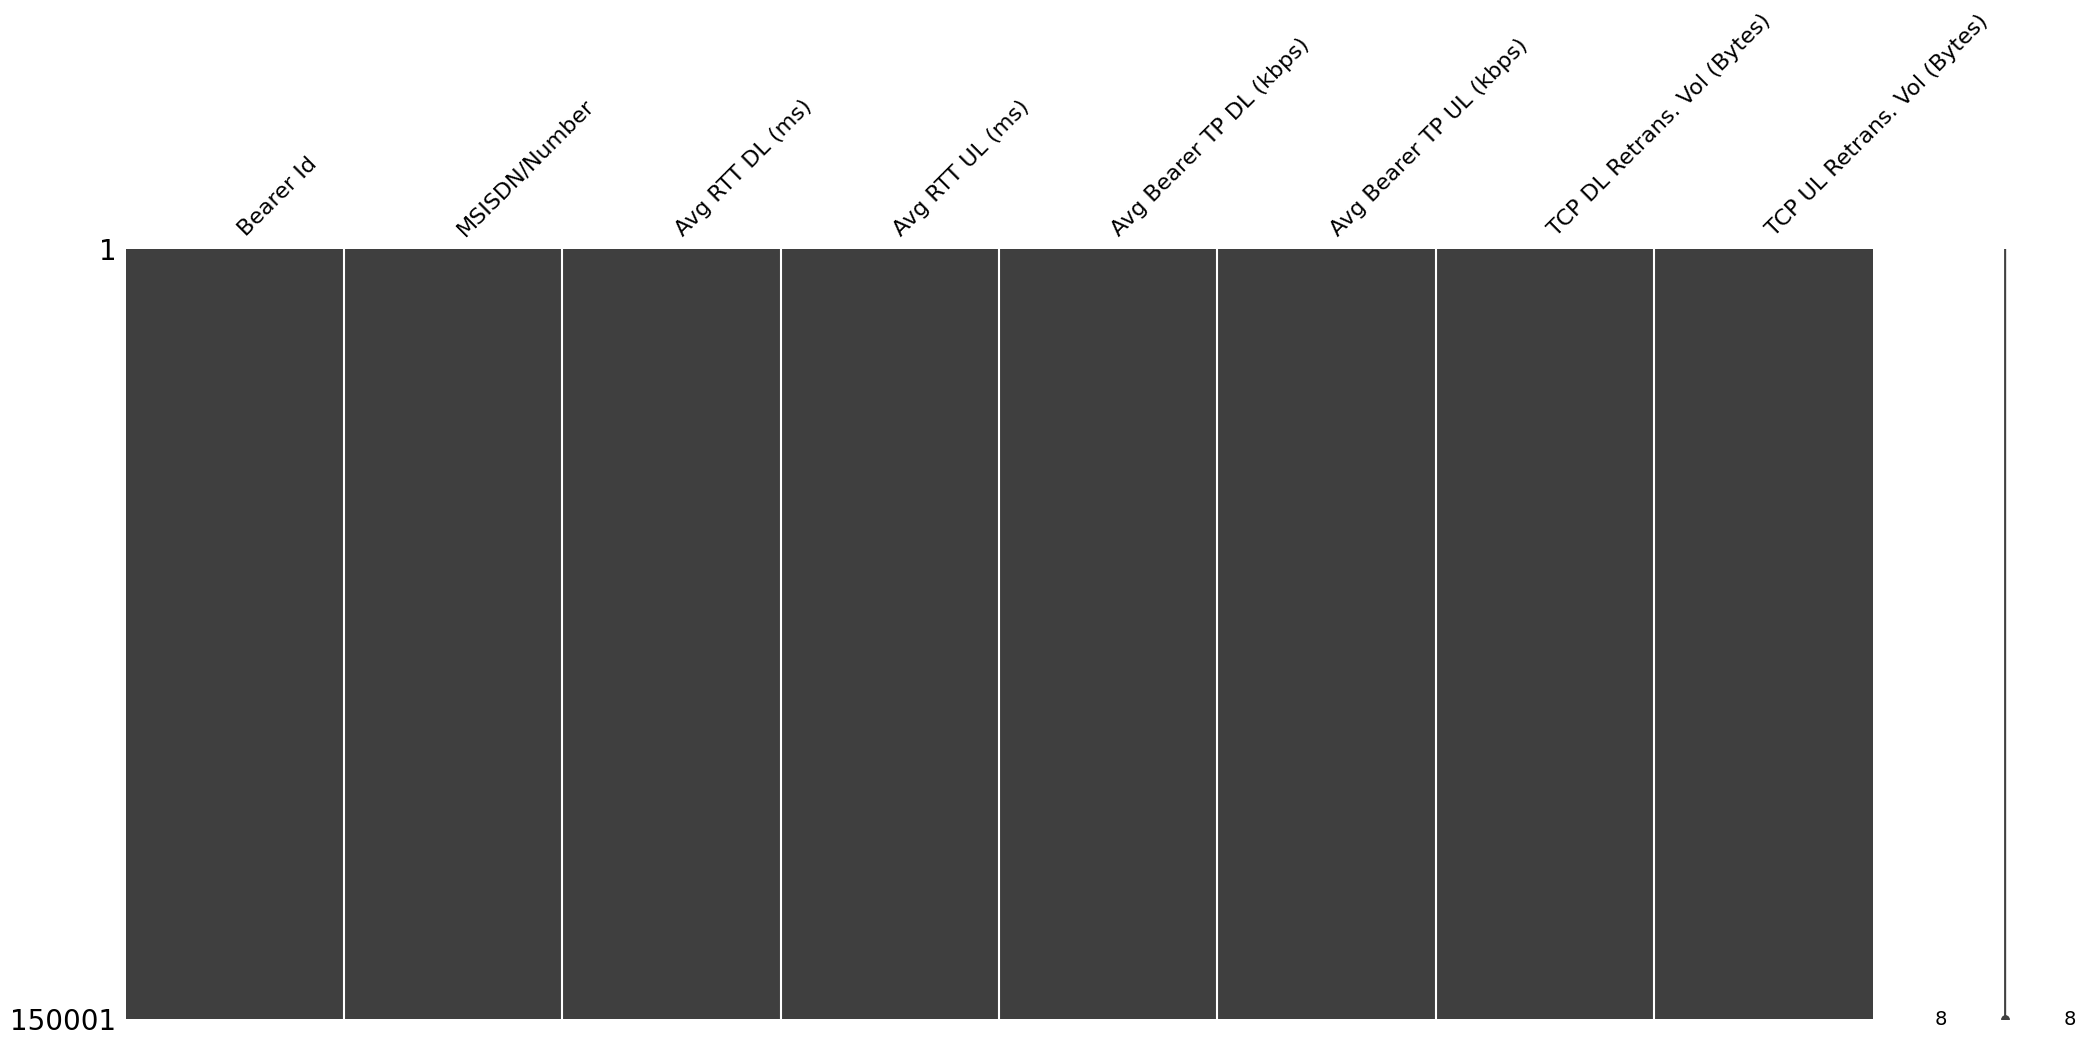

In [6]:
replace_missing_values(df)

### Check for missing value

In [7]:
#rows
duplicated_rows = df[df.duplicated()]
if len(duplicated_rows) > 0:
    print(f"Duplicate rows found: {len(duplicated_rows)}")
else:
    print("No duplicate rows found.")

# columns
duplicated_columns = df.columns[df.columns.duplicated()]
if len(duplicated_columns) > 0:
    print(f"Duplicate columns found: {', '.join(duplicated_columns)}")
else:
    print("No duplicate columns found.")

Duplicate rows found: 72
No duplicate columns found.


Since there is a duplicated rows, I would like to drop the duplicated rows, then reset the index after droping.

In [8]:
# Drop duplicate rows based on all columns
df = df.drop_duplicates()

# Reset the index after dropping duplicates
df = df.reset_index(drop=True)

In [9]:
#rows check again
duplicated_rows = df[df.duplicated()]
if len(duplicated_rows) > 0:
    print(f"Duplicate rows found: {len(duplicated_rows)}")
else:
    print("No duplicate rows found.")

No duplicate rows found.


In [10]:
# Storing column names as a list
column_names = df.select_dtypes(exclude=['object']).columns.tolist()

for column in column_names:
    # Check for outliers
    outliers = detect_outliers_zscore(df, column)
    if len(outliers) > 0:
        # print(f"Outliers detected in column {column}. Length: {len(outliers)}")
        # Remove outliers
        df = remove_outliers(df, column)

## Aggregate Experience Metrics

In [11]:
experience_metrics_df = aggregate_experience_metrics(df)
experience_metrics_df.head()

,MSISDN/Number,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes)
0,3.360100e+10,46.000000,0.000000,37.0,39.0,2.080991e+07,759658.664811
1,3.360100e+10,30.000000,1.000000,48.0,51.0,2.080991e+07,759658.664811
2,3.360100e+10,109.795706,17.662883,48.0,49.0,2.080991e+07,759658.664811
3,3.360101e+10,69.000000,15.000000,204.0,44.0,1.066000e+03,759658.664811
4,3.360101e+10,28.000000,0.000000,23.0,40.0,2.080991e+07,759658.664811


In [12]:
experience_metrics_df = experience_metrics_df[experience_metrics_df['MSISDN/Number'] != 41882819545.02736]

In [13]:
experience_metrics_df.tail()

,MSISDN/Number,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes)
102763,3.378997e+10,48.000000,5.000000,23.0,44.0,2.080991e+07,759658.664811
102764,3.378998e+10,109.795706,17.662883,42.0,52.0,2.080991e+07,759658.664811
102765,3.379000e+10,42.000000,10.000000,9978.0,387.0,2.150440e+05,3001.000000
102766,3.379000e+10,34.000000,6.000000,68.0,48.0,2.080991e+07,759658.664811
102768,3.197021e+12,109.795706,17.662883,1.0,0.0,2.080991e+07,759658.664811


### Normalize the experience metrics and Determine Optimal Clusters by Elbow Method


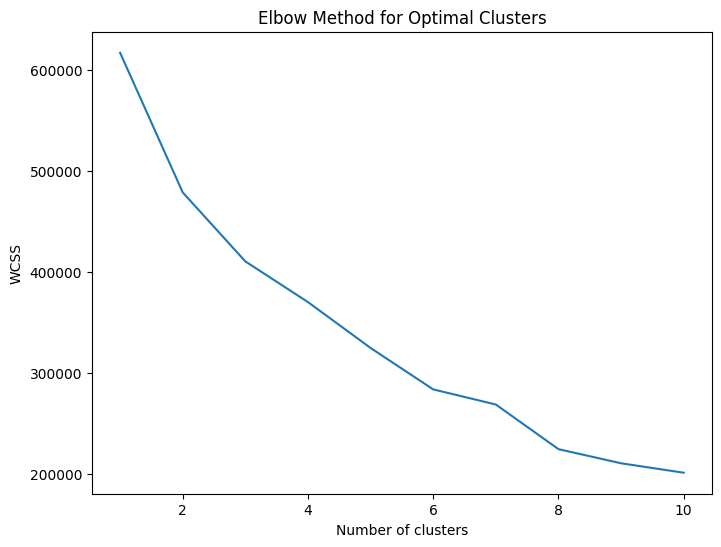

In [14]:
normalized_experience_df = normalize_experience_data(experience_metrics_df)
# Plot the elbow method
plot_elbow_method(normalized_experience_df)

## Apply K_Means clustering

In [15]:
num_clusters = 6
clustered_experience_df, kmeans_model = apply_kmeans(normalized_experience_df, num_clusters)

centers = kmeans_model.cluster_centers_
# Export the value of the cluster centers as JSON for task 4
import json
cluster_centers = {f'cluster_{i}': centers[i].tolist() for i in range(num_clusters)}
with open('../assets/experience_cluster_centers.json', 'w') as f:
    json.dump(cluster_centers, f)

In [16]:
# Export the experience metrics data to a CSV file
clustered_experience_df.to_csv("../assets/experience_metrics.csv", index=False)

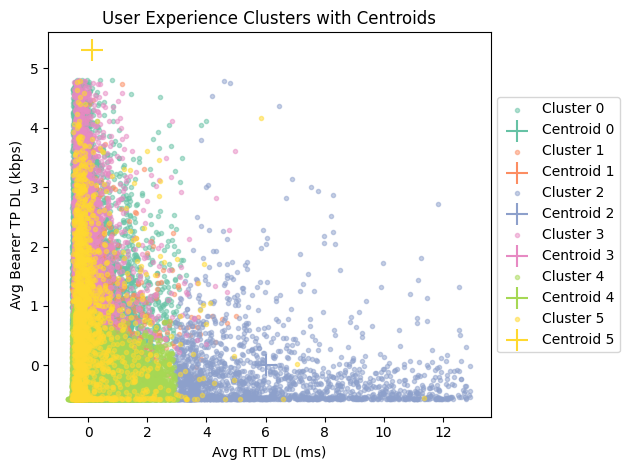

In [17]:
# Visualize the clusters
visualize_clusters_with_centroids(clustered_experience_df, kmeans_model, num_clusters)

This plot shows the clusters formed using K-means clustering, where each cluster is represented by a different color.

Different clusters represent groups of user experiences, with each group showing different combinations of RTT and throughput.
* For example, **Cluster 2** (light blue), these users have low RTT and moderately low throughput. They might be in areas where network speed is acceptable but not very fast.
* On the other hand, **Cluster 6** might represent users with higher throughput but very low RTT, this provides a seamless, fast, and responsive user experience.